# Optimization

In this notebook, we explore various optimization problems and algorithms.

## TOC
* [Automatic differentiation](#AD)
* [Stochastic gradient descent](#SGD)

In [5]:

import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os
figdir = "../figures" # set this to '' if you don't want to save figures
def save_fig(fname):
    if figdir:
        plt.savefig(os.path.join(figdir, fname))

import numpy as onp
onp.set_printoptions(precision=3)
import jax
import jax.numpy as np
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

import torch
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print("current device {}".format(torch.cuda.current_device()))
else:
    print("Torch cannot find GPU")
    
import tensorflow as tf
from tensorflow import keras
print("tf version {}".format(tf.__version__))
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("TF cannot find GPU")



jax version 0.1.39
jax backend gpu
torch version 1.1.0
GeForce RTX 2080 with Max-Q Design
current device 0
tf version 2.0.0-dev20190629


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: unknown error

## Automatic differentiation <a class="anchor" id="AD"></a>

In this section we  illustrate various AD libraries.

### AD in JAX  <a class="anchor" id="AD-jax"></a>

For some examples of using JAX to compute the gradients, Jacobians and Hessians of simple linear and quadratic functions,
see [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/linear_algebra.ipynb#AD-jax).
For an example of using JAX to compute the gradient of the NLL for binary logistic regression,
see [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/linear_algebra.ipynb#AD-jax-log).

More details on JAX's autodiff can be found in the official [autodiff cookbook](https://github.com/google/jax/blob/master/notebooks/autodiff_cookbook.ipynb).


### AD in TF  <a class="anchor" id="AD-TF"></a>

Unfinished.

### AD in PyTorch  <a class="anchor" id="AD-pytorch"></a>

Unfinished.

## Stochastic gradient descent <a class="anchor" id="SGD"></a>

In this section we  illustrate how to implement SGD.

### SGD in Jax <a class="anchor" id="SGD-jax"></a>

JAX has a minimal optimization library focused on stochastic first-order optimizers. Every optimizer is modeled as an (`init_fun`, `update_fun`, `get_params`) triple of functions. The `init_fun` is used to initialize the optimizer state, which could include things like momentum variables, and the `update_fun` accepts a gradient and an optimizer state to produce a new optimizer state. The `get_params` function extracts the current iterate (i.e. the current parameters) from the optimizer state. The parameters being optimized can be ndarrays or arbitrarily-nested list/tuple/dict structures, so you can store your parameters however you’d like.

We give some examples below.

### SGD for logistic regression using Jax <a class="anchor" id="SGD-logreg-jax"></a>

We consider a convex problem, namely MLE for binary logistic regression,
where we compute the exact optimum. We solve this using a batch solver (BFGS) to create the gold standard.
We use Jax for the gradient computations (see  [this notebook](https://github.com/probml/pyprobml/blob/master/notebooks/linear_algebra.ipynb#AD-jax-logreg) for details). We also use Jax to implement SGD.

In [22]:
# First we create a dataset.

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"][:,:3] # Just take first 3 features to make problem harder
y = (iris["target"] == 2).astype(onp.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4


X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)


In [23]:
# Now let's find the MLE using sklearn. We will use this as the "gold standard"

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)
w_mle_sklearn = np.ravel(log_reg.coef_)
print(w_mle_sklearn)


[-5.457 -4.877  9.756]


In [24]:
# Now we try to fit the model ourselves by defining a suitable objective.

def sigmoid(x): return 0.5 * (np.tanh(x / 2.) + 1)

def predict_logit(weights, inputs):
    return np.dot(inputs, weights) # Already vectorized

def predict_prob(weights, inputs):
    return sigmoid(predict_logit(weights, inputs))

from jax.scipy.special import logsumexp
#from scipy.misc import logsumexp

def NLL(weights, batch):
    # Use log-sum-exp trick
    inputs, targets = batch
    # p1 = 1/(1+exp(-logit)), p0 = 1/(1+exp(+logit))
    logits = predict_logit(weights, inputs).reshape((-1,1))
    N = logits.shape[0]
    logits_plus = np.hstack([np.zeros((N,1)), logits]) # e^0=1
    logits_minus = np.hstack([np.zeros((N,1)), -logits])
    logp1 = -logsumexp(logits_minus, axis=1)
    logp0 = -logsumexp(logits_plus, axis=1)
    logprobs = logp1 * targets + logp0 * (1-targets)
    return -np.sum(logprobs)/N



In [25]:
# Batch solver.

import scipy.optimize

def training_loss(w):
    return NLL(w, (X_train, y_train))

def training_grad(w):
    return grad(training_loss)(w)

onp.random.seed(43)
w_init = onp.random.randn(D)
w_mle_scipy = scipy.optimize.minimize(training_loss, w_init, jac=training_grad, method='BFGS').x
print(w_mle_sklearn)
print(w_mle_scipy)
assert np.allclose(w_mle_sklearn, w_mle_scipy, atol=1e-1) # parameters are approximately equal

prob_scipy = predict_prob(w_mle_scipy, X_test)
prob_sklearn = predict_prob(w_mle_sklearn, X_test)
print(np.round(prob_scipy, 3))
print(np.round(prob_sklearn, 3))
assert np.allclose(prob_scipy, prob_sklearn, atol=1e-2) # predictions match closely


[-5.457 -4.877  9.756]
[-5.457 -4.878  9.757]
[0.251 0.    1.    0.048 0.019 0.    0.    0.047 0.341 0.001 0.21  0.
 0.    0.    0.    0.01  0.998 0.009 0.297 0.998 0.    0.471 0.    0.998
 0.689 0.386 1.    0.992 0.    0.    0.    0.    0.    0.    0.    0.901
 0.001 0.    0.    0.    0.993 0.004 0.003 0.    0.    0.004 0.848 0.974
 0.    0.935]
[0.251 0.    1.    0.048 0.019 0.    0.    0.047 0.34  0.001 0.21  0.
 0.    0.    0.    0.01  0.998 0.009 0.297 0.998 0.    0.471 0.    0.998
 0.689 0.386 1.    0.992 0.    0.    0.    0.    0.    0.    0.    0.901
 0.001 0.    0.    0.    0.993 0.004 0.003 0.    0.    0.004 0.848 0.974
 0.    0.935]


Epoch 0, train NLL 0.6990973949432373
Epoch 500, train NLL 0.13671793043613434
Epoch 1000, train NLL 0.13282862305641174
Epoch 1500, train NLL 0.13254371285438538
[0.251 0.    1.    0.048 0.019 0.    0.    0.047 0.341 0.001 0.21  0.
 0.    0.    0.    0.01  0.998 0.009 0.297 0.998 0.    0.471 0.    0.998
 0.689 0.386 1.    0.992 0.    0.    0.    0.    0.    0.    0.    0.901
 0.001 0.    0.    0.    0.993 0.004 0.003 0.    0.    0.004 0.848 0.974
 0.    0.935]
[0.237 0.    1.    0.048 0.019 0.    0.    0.045 0.32  0.001 0.197 0.
 0.    0.    0.    0.01  0.998 0.009 0.28  0.997 0.    0.442 0.    0.997
 0.648 0.36  0.999 0.989 0.    0.    0.    0.    0.    0.    0.    0.882
 0.001 0.    0.    0.    0.991 0.005 0.003 0.    0.    0.004 0.823 0.966
 0.001 0.919]


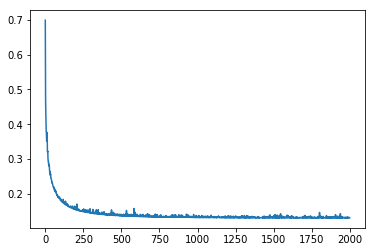

In [26]:
# Finally we get to SGD.

from jax.experimental import optimizers
import itertools
import time

schedule = optimizers.constant(step_size=0.1)
#schedule = optimizers.exponential_decay(step_size=0.1, decay_steps=10, decay_rate=0.9)
#schedule = optimizers.piecewise_constant([50, 100], [0.1, 0.05, 0.01])

opt_init, opt_update, get_params = optimizers.momentum(step_size=schedule, mass=0.9)
#opt_init, opt_update, get_params = optimizers.adam(step_size=schedule)

    
@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(NLL)(params, batch)
  return opt_update(i, g, opt_state) # update internal state using gradient and iteration number

# Make sure everything is reproducible!
onp.random.seed(43)
w_init = onp.random.randn(D)
opt_state = opt_init(w_init)
num_epochs = 2000
loss_history = []

batch_size = 10
num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
    rng = onp.random.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx], y_train[batch_idx]
batches = data_stream()

itercount = itertools.count()
for epoch in range(num_epochs):
    start_time = time.time()
    for _ in range(num_batches):
      opt_state = update(next(itercount), opt_state, next(batches))
    epoch_time = time.time() - start_time
    params = get_params(opt_state)
    train_loss = NLL(params, (X_train, y_train))
    loss_history.append(train_loss)
    if epoch % 500 == 0:
        #print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print('Epoch {}, train NLL {}'.format(epoch, train_loss))
        
w_mle_jax = get_params(opt_state)

# Rather than comparing parameters, we compare predictions
prob_scipy = predict_prob(w_mle_scipy, X_test)
prob_jax = predict_prob(w_mle_jax, X_test)
print(np.round(prob_scipy, 3))
print(np.round(prob_jax, 3))
assert np.allclose(prob_jax, prob_sklearn, atol=1e-1) # This is only true for some random seeds!



(DeviceArray(0.131, dtype=float32), DeviceArray(0.14, dtype=float32))

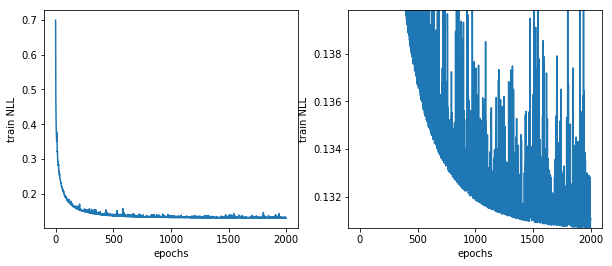

In [35]:
plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.plot(loss_history)
ax.set_xlabel('epochs')
ax.set_ylabel('train NLL')
#ax.set_ylim(np.min(loss_history), 0.2*np.max(loss_history))

ax = plt.subplot(122)
ax.plot(loss_history)
ax.set_xlabel('epochs')
ax.set_ylabel('train NLL')
ax.set_ylim(np.min(loss_history), 0.2*np.max(loss_history))